# TP2 Visión Por Computadora 1

* Mauro Aguirregaray
* Fabricio Denardi

**Consideraciones generales**
1. Siempre que lo consideramos necesario, realizamos un tipado de las funciones como una explicación detallada.
2. Intentamos nomenclar siempre en inglés variables, métodos, clases etc, aunque para un mejor entendimiento los comentarios los hicimos en español.

In [1]:
%matplotlib  inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import os
import time
import copy<zx

## Implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ 

Primero debemos entender que expone el paper mencionado. En este calcula una métrica a la que llama FM y cuanto más alta es está métrica se espera una imagen con mayor enfoque, este razonamiento parte de que en el espacio espectral de la imagen, cuanto más centrados estén los puntos menos variación de frecuencia tendremos y por lo tanto es más esperable ver una imagen desenfoada. La ventaja de este método es que no requiere una imagen de referencia para poder asegurar que estemos en un caso de desenfoque.

De nuestra parte debemos implementar un método que pase por los siguientes puntos mencionados en el paper:

**Input:** Image I of size M×N.

**Output:** Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure

**Step 1:** Compute F which is the Fourier Transform representation of image I

**Step 2:** Find Fc which is obtained by shifting the origin of F to centre.

**Step 3:** Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.

**Step 4:** Calculate M = max (AF) where M is the maximum value of the frequency component in F.

**Step 5:** Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.

**Step 6:** Calculate Image Quality measure (FM) from equation (1).

$$
\text{Image Quality Measure (FM)} = \frac{T_H}{M \times N}
$$


In [9]:
def calculate_image_quality_measure_FM(img:np.ndarray) -> float:

    #Step 1: Compute F which is the Fourier Transform representation of image I 
    image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    f = np.fft.fft2(image_gray)

    #Step 2:  Find Fc which is obtained by shifting the origin of F to centre. 
    fc = np.fft.fftshift(f)

    #Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I. 
    af = np.abs(fc)

    #Step 4:  Calculate M = max (AF) where M is the maximum value of the frequency component in F. 
    m = np.max(af)

    #Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    threshold = m / 1000
    th = np.sum(af > threshold)

    #Step 6: Calculate Image Quality measure (FM) from equation (1).
    fm = th / (img.shape[0] * img.shape[1])

    return fm   

Y esto debemos aplicarlo a tres experimentos:
1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

Generamos entonces una lista de funciones auxiliares para calcular las métricas y armar los videos:

In [2]:
def get_center(height:int, width:int, roi_percentage:float=0.05) -> tuple:
    '''Devuelve las coordenadas del centro'''
    total_area = height * width
    roi_area = roi_percentage * total_area
    
    # Calcular el tamaño de la ROI
    roi_size = int(np.sqrt(roi_area)) #Se asume por simplicidad y ante falta de especificación en el enunciado que será cuadrada
    
    # Calcular las coord
    cx, cy = width // 2, height // 2  # Coordenadas del centro de la imagen
    x1, y1 = cx - roi_size // 2, cy - roi_size // 2  # Corner superior izquierdo
    x2, y2 = cx + roi_size // 2, cy + roi_size // 2  # Corner inferior derecho
    
    # Evitar desbordes
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(width, x2), min(height, y2)
    
    return x1,y1,x2,y2

In [3]:
def get_center_roi(image: np.ndarray, roi_percentage:float=0.05) -> np.ndarray:
    '''Devuelve la región central que ocupe un % pasado como parámetro'''
    
    if not (0.05 <= roi_percentage <= 0.10):
        raise ValueError("El porcentaje de ROI debe estar entre 5% y 10%.") 

    # Obtener las dimensiones del área
    height, width = image.shape[:2]
    
    x1,y1,x2,y2 = get_center(height,width,roi_percentage)

    # ROI
    roi = image[y1:y2, x1:x2]
    return roi 

In [4]:
def calculate_spacing(image_size, cell_size, num_cells_x, num_cells_y):
    '''Calculamos el espacio entre celdas'''
    image_height, image_width = image_size
    cell_height, cell_width = cell_size
    
    total_width = num_cells_x * cell_width
    total_height = num_cells_y * cell_height
    
    spacing_x = (image_width - total_width) // (num_cells_x + 1)
    spacing_y = (image_height - total_height) // (num_cells_y + 1)
    
    return spacing_x, spacing_y

In [5]:
def get_grid_regions(image:np.ndarray, N:int, M:int,cell_size = (10, 10)):
    '''Calcula las regiones'''
    image_height, image_width = image.shape[:2]
    cell_height, cell_width = cell_size
    
    spacing_x, spacing_y = calculate_spacing((image_height, image_width), cell_size, N, M)
    
    grid_elements = []
    
    for i in range(M):
        for j in range(N):
            start_x = j * (cell_width + spacing_x) + spacing_x
            start_y = i * (cell_height + spacing_y) + spacing_y
            end_x = start_x + cell_width
            end_y = start_y + cell_height
            
            if end_x <= image_width and end_y <= image_height:
                grid_elements.append((image[start_y:end_y, start_x:end_x], (start_x, start_y, end_x, end_y)))
    
    return grid_elements #Me devuelve una lista de imágenes

In [6]:
def get_fm_metric_for_grid(fm_metric_array: list):
    return np.mean(fm_metric_array) #Me devuelve el fm medio de toda la grilla estudiada

In [7]:
def get_frames(video_path):
    cap = cv.VideoCapture(video_path)
    frames = []

    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()

    

    return frames, height, width,fps

Con todas las funciones auxiliares calculamos la métrica para cada frame en cada uno de los casos del ejercicio:

In [10]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
roi_center_percentage = 0.05
region_nxm_to_analize = {"(3,3)":[(3,3),[],[]],"(7,5)":[(7,5),[],[]],"(9,6)":[(9,6),[],[]]}


print(f"Cantidad de frames del video {video_name}: {len(frames)}")

fm_all_frame_video = []
fm_center_video = []
for frame in frames:
    fm_all_frame = calculate_image_quality_measure_FM(frame)
    fm_all_frame_video.append(fm_all_frame)
    
    fm_center = calculate_image_quality_measure_FM(get_center_roi(frame,roi_center_percentage))
    fm_center_video.append(fm_center)
    
    for k,v in region_nxm_to_analize.items():
        #Obtener las regiones segun la matriz a analizar
        regions = get_grid_regions(frame,v[0][0],v[0][1])

        regions_coords = []
        tmp_fm = []
        for region in regions:
            tmp_fm.append(calculate_image_quality_measure_FM(region[0]))
            regions_coords.append(region[1])

        total_fm_region = get_fm_metric_for_grid(tmp_fm)
        region_nxm_to_analize[k][1].append(total_fm_region)
        #region_nxm_to_analize[k][2].append(regions_coords)

Cantidad de frames del video focus_video.mov: 171


### 1. Medición sobre todo el frame

Primero hacemos la predicción para el caso midiendo todo el frame

In [14]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
print(f"Cantidad de frames del video {video_name}: {len(frames)}")

fm_all_frame_video = []
for frame in frames:
    fm_all_frame = calculate_image_quality_measure_FM(frame)
    fm_all_frame_video.append(fm_all_frame)

Cantidad de frames del video focus_video.mov: 171


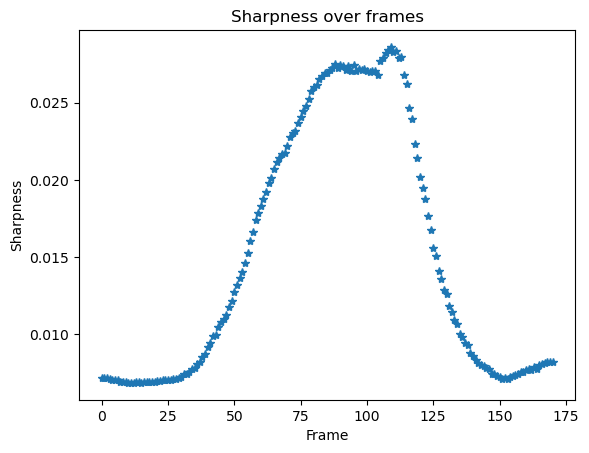

In [16]:
# Grafica sobre todo el frame
plt.plot(fm_all_frame_video,'*', label='Full')
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames')
plt.show()

Se observa claramente en la gráfica el momento en que el video logra enfocarse y cómo luego vuelve a desenfocarse. Además resulta interesante observar que la métrica aumenta casi 10 veces entre los puntos de mayor y menor desenfoque.

### 2. Medición sobre una ROI ubicada en el centro del frame

In [17]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
roi_center_percentage = 0.05
print(f"Cantidad de frames del video {video_name}: {len(frames)}")

fm_center_video = []
for frame in frames:
    fm_center = calculate_image_quality_measure_FM(get_center_roi(frame,roi_center_percentage))
    fm_center_video.append(fm_center)

Cantidad de frames del video focus_video.mov: 171


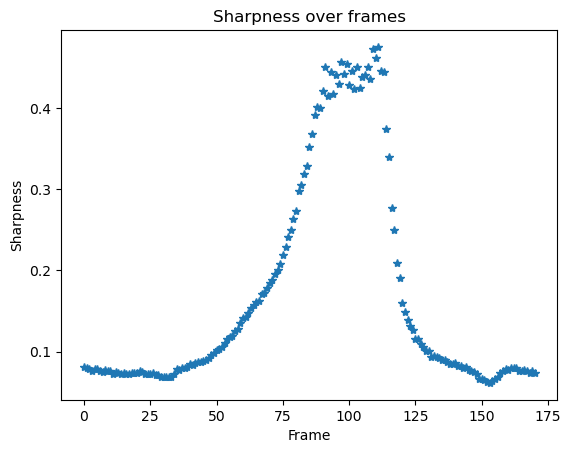

In [18]:
# Grafica sobre todo el frame
plt.plot(fm_center_video,'*', label='Full')
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames')
plt.show()

Este caso es similar al anterior pero más focalizado, la métrica se comporta mejor que en el caso anterior pero el lapso de tiempo en enfoque es mucho menor. Es interesante observar que si nos focalizamos en el centro de la imagen el comportamiento de la percepción (según la métrica) varía.

### 3. Medición sobre una grilla

Elegimos 3 grillas diferentes para este estudio 3x3, 7x5 y 9x6.

In [38]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
region_nxm_to_analize = {"(3,3)":[(3,3),[],[]],"(7,5)":[(7,5),[],[]],"(9,6)":[(9,6),[],[]]}
print(f"Cantidad de frames del video {video_name}: {len(frames)}")

for frame in frames:    
    for k,v in region_nxm_to_analize.items():
        #Obtener las regiones segun la matriz a analizar
        regions = get_grid_regions(frame,v[0][0],v[0][1])
        tmp_fm = []
        for region in regions:
            tmp_fm.append(calculate_image_quality_measure_FM(region[0]))
            regions_coords.append(region[1])

        total_fm_region = get_fm_metric_for_grid(tmp_fm)
        region_nxm_to_analize[k][1].append(total_fm_region)

Cantidad de frames del video focus_video.mov: 171


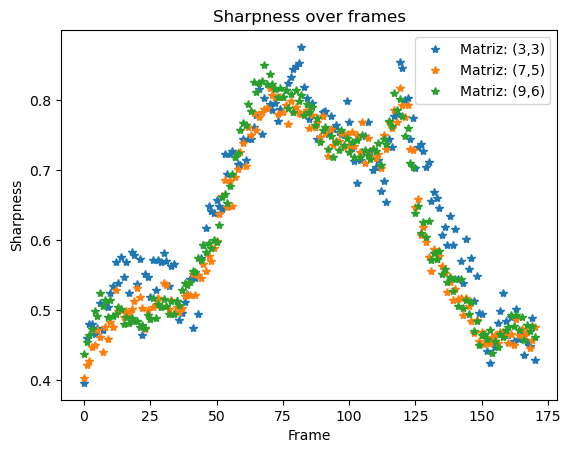

In [39]:
for k,v in region_nxm_to_analize.items():
    plt.plot(v[1],'*', label=f'Matriz: {k}')

plt.legend()
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames')
plt.show()

El caso de la grilla es particular pues tenemos casos con mucho más ruido de lo que teniamos antes y que si bien se entiende dónde encontramos los frames con mayor enfoque, la métrica apenas mejora en %.

Una explicación para esto la encontramos en el paper *Analysis Of Foces Measure Operators* que en el punto 3.3.1 habla de que la medida de enfoque es muy sensible al tamaño de la ventana y esto nos puede estar afectando a la métrica.

Para chequear este punto y sólo con la grilla de 3x3 repetiremos el cálculo aumentando el tamaño de la celda

In [28]:
video_name ="focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
region_nxm_to_analize = {"(3,3)":[(3,3),[],[]]}
print(f"Cantidad de frames del video {video_name}: {len(frames)}")

for frame in frames:    
    for k,v in region_nxm_to_analize.items():
        #Obtener las regiones segun la matriz a analizar
        regions = get_grid_regions(frame,v[0][0],v[0][1], cell_size=(30, 30))
        tmp_fm = []
        for region in regions:
            tmp_fm.append(calculate_image_quality_measure_FM(region[0]))
            regions_coords.append(region[1])

        total_fm_region = get_fm_metric_for_grid(tmp_fm)
        region_nxm_to_analize[k][1].append(total_fm_region)

Cantidad de frames del video focus_video.mov: 171


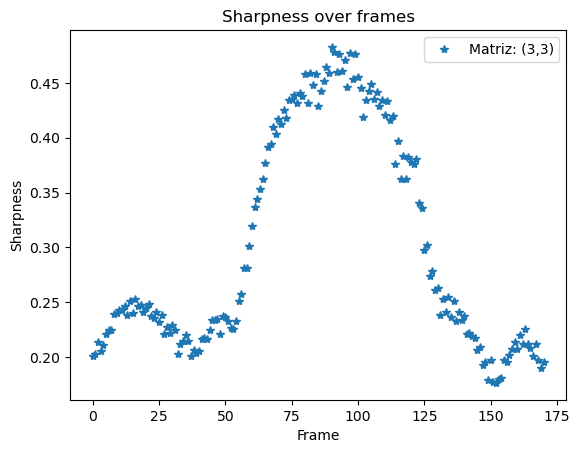

In [29]:
for k,v in region_nxm_to_analize.items():
    plt.plot(v[1],'*', label=f'Matriz: {k}')

plt.legend()
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames')
plt.show()

Tal como se mencionaba en el paper mencionado el aumentar el tamaño de la celda sin cambiar el tamaño de la grilla modifico notoriamente el comportamiento de la métrica, y ahora se comporta de manera mucho más similar a los primeros casos de estudio.

### Videos

Definimos algunas funciones auxiliares para crear los videos:

In [23]:
def remove_file_if_exists(file_path:str):
    '''Elimina archivo en caso que exista'''
    if os.path.exists(file_path):
        os.remove(file_path)

In [24]:
def get_sharpness_values_umbral(sharpness_values, sigma = 3):
    '''mean_sharpness = np.mean(sharpness_values)
    std_dev_sharpness = np.std(sharpness_values)
    lower_bound = mean_sharpness - sigma * std_dev_sharpness
    upper_bound = mean_sharpness + sigma * std_dev_sharpness'''

    max_sharpness = np.max(sharpness_values)
   
    lower_bound = max_sharpness - sigma * max_sharpness
    upper_bound = max_sharpness + sigma * max_sharpness


    return lower_bound, upper_bound

In [25]:
def build_video(frames, sharpness_values, output_path, regions, region_line_widht = 2, tolerance=0.1, ok_color = (0, 255, 0), no_ok_color = (0, 0, 255)):
    remove_file_if_exists(output_path)
    lower_bound, upper_bound = get_sharpness_values_umbral(sharpness_values,tolerance)


    height, width = frames[0].shape[:2]
    fps = video_fps  

    # Salida de video
    fourcc = cv.VideoWriter_fourcc(*'avc1')
    out = cv.VideoWriter(output_path, fourcc, fps, (width, height))

    for idx, frame in enumerate(frames):

        color = ok_color if lower_bound <= sharpness_values[idx] <= upper_bound else no_ok_color

        for (x1, y1, x2, y2) in regions:
            cv.rectangle(frame, (x1, y1), (x2, y2), color, region_line_widht)

        out.write(frame)

    out.release()

    # Espera para asegurar que el buffer se vacíe. A pesar del release nos mezclaba los videos
    time.sleep(2)

In [26]:
def get_out_file_name(file):
    '''Devuelve el path relativo'''
    return os.path.join('outs',file)

In [27]:
#Todo el frame
all_frame_region = [(0,0,video_width, video_height)] # Única región (x1, y1, x2, y2)

#Centro
x1, y1, x2, y2 = get_center(video_height,video_width)
centered_frame_region = [(x1, y1, x2, y2)] 

all_frames = copy.deepcopy(frames)
build_video(all_frames, fm_all_frame_video,get_out_file_name('out_all_frame.mp4'),all_frame_region, region_line_widht=6)

centered_frames = copy.deepcopy(frames)
build_video(centered_frames, fm_center_video,get_out_file_name('centered_all_frame.mp4'),centered_frame_region, region_line_widht=2, tolerance=0.3)



for k,v in region_nxm_to_analize.items():
    region_frames = copy.deepcopy(frames)
    regions = [x[1] for x in get_grid_regions(region_frames[0], v[0][0], v[0][1])]

    build_video(region_frames, fm_center_video,get_out_file_name(f'{k}_frame.mp4'),regions, region_line_widht=1, tolerance=0.3)
 

## Otra métrica de cálculo de enfoque (Gradient Energy)

Para comparar elegiremos la métrica de enfoque conocida como "Gradient Energy" (GRA2)

In [30]:
def calculate_gradient_energy(image: np.ndarray) -> float:
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # Calculamos los gradientes en ambas direcciones
    gradient_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    gradient_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    
    # Calculamos la suma de los gradientes (que es el método gradient energy)
    gradient_energy = np.sum(gradient_x**2 + gradient_y**2)
    
    return gradient_energy

Dejamos la bibliografía del método [Sobel](https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html) de OPENCV para calcular derivadas direccionales

Hacemos el cálculo para los 5 casos

In [45]:
video_name = "focus_video.mov"
frames, video_height, video_width, video_fps = get_frames(video_name)
roi_center_percentage = 0.05
region_nxm_to_analyze = {"(3,3)": [(3,3),[],[]], "(7,5)": [(7,5),[],[]], "(9,6)": [(9,6),[],[]]}

print(f"Cantidad de frames del video {video_name}: {len(frames)}")

gra2_all_frame_video = []
gra2_center_video = []
for frame in frames:
    gra2_all_frame = calculate_gradient_energy(frame)
    gra2_all_frame_video.append(gra2_all_frame)
    
    gra2_center = calculate_gradient_energy(get_center_roi(frame, roi_center_percentage))
    gra2_center_video.append(gra2_center)
    
    for k, v in region_nxm_to_analyze.items():
        # Obtener las regiones según la matriz a analizar
        regions = get_grid_regions(frame, v[0][0], v[0][1])

        regions_coords = []
        tmp_gra2 = []
        for region in regions:
            tmp_gra2.append(calculate_gradient_energy(region[0]))
            regions_coords.append(region[1])

        total_gra2_region = get_fm_metric_for_grid(tmp_gra2)
        region_nxm_to_analyze[k][1].append(total_gra2_region)

# Aquí puedes hacer cualquier procesamiento adicional o análisis con gra2_all_frame_video, gra2_center_video, y region_nxm_to_analyze


Cantidad de frames del video focus_video.mov: 171


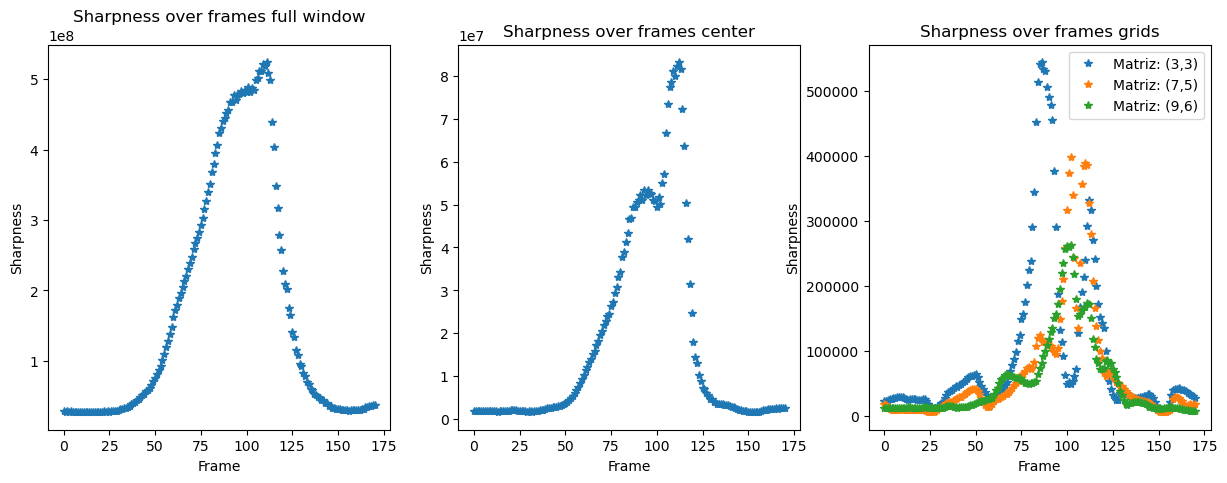

In [47]:
# Mostrar las imágenes
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(gra2_all_frame_video,'*', label='Full')
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames full window')

plt.subplot(1,3,2)
plt.plot(gra2_center_video,'*', label='Full')
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames center')


plt.subplot(1,3,3)
for k,v in region_nxm_to_analyze.items():
    plt.plot(v[1],'*', label=f'Matriz: {k}')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Sharpness')
plt.title('Sharpness over frames grids')

plt.show()

Como para finalizar el tp se observa que otra métrica como puede ser Gradient Energy se comporta:

* Muy similar si estudiamos todo el frame
* Si estudiamos particularmente el centro de la imagen nota una clara diferencia entre el punto de mayor enfoque 
* Para la grilla muestra demasiado ruido y no representa de buena manera el tiempo de mayor enfoque.